In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style(style="darkgrid")
import os
import csv
import matplotlib.pyplot as plt
import statistics as stat
from scipy import spatial
from scipy.signal import savgol_filter,argrelextrema
import sys
from scipy.optimize import curve_fit
from math import sin, pi

In [76]:
lightname = "light(ppfd)"
timename = "time[s]"
odname = "OD(680nm)"

cols = [timename,250,500,750,1000,1250,1500,1750,2000,"replicate"]
colnames = []
for i in range(len(cols)):
    if i == 0 or i==len(cols)-1:
        colnames.append(cols[i])
        continue
    col = odname+str(cols[i])
    colnames.append(col)
print(colnames)

['time[s]', 'OD(680nm)250', 'OD(680nm)500', 'OD(680nm)750', 'OD(680nm)1000', 'OD(680nm)1250', 'OD(680nm)1500', 'OD(680nm)1750', 'OD(680nm)2000', 'replicate']


In [81]:
filenames = ['A4_A_09302020.csv','A4_B_10012020.csv','A4_C_10022020.csv']
path = os.getcwd()
replicates = []

for i,name in enumerate(filenames):
    filepath = os.path.join(path,name)
    A = pd.read_csv(name)
    A = A.drop('temp',axis=1)
    repname = [i] * len(A)
    A["replicate"] = repname
    A.columns = colnames
    
    #removing duplicate times
    len0 = len(A)
    A = A.drop_duplicates(subset=[timename])
    len1 = len(A)
    diff = len0 - len1
    if diff != 0:
        print(name+":: Dropped",diff,"rows with duplicate \""+timename+"\" values")
    A = pd.wide_to_long(A, odname, i=timename, j=lightname)
    replicates.append(A)
#     print(i)
df = pd.concat(replicates)
df.reset_index(inplace=True)
df

A4_C_10022020.csv:: Dropped 2 rows with duplicate "time[s]" values


,time[s],light(ppfd),replicate,OD(680nm)
0,0,250,0,0.039
1,300,250,0,0.035
2,600,250,0,0.034
3,900,250,0,0.034
4,1200,250,0,0.034
...,...,...,...,...
10083,145506,2000,2,2.775
10084,145806,2000,2,2.775
10085,146106,2000,2,2.696
10086,146406,2000,2,2.775


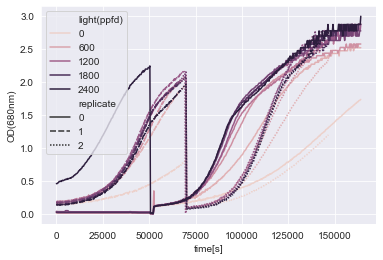

In [86]:
plt.figure()
sns.lineplot(x=timename, y=odname,
             hue=lightname, style="replicate",
             data=df)

In [33]:
# https://stackoverflow.com/questions/25057835/get-the-mean-across-multiple-pandas-dataframes
by_row_index = df.groupby(df.index)
df_means = by_row_index.mean()
df_means

,time[s],250,500,750,1000,1250,1500,1750,2000
0,0.0,0.104333,0.118667,0.116000,0.132667,0.128333,0.127000,0.102333,0.242333
1,300.0,0.104333,0.119333,0.114667,0.133000,0.129667,0.124667,0.104000,0.244000
2,600.0,0.105333,0.118333,0.115667,0.135333,0.131000,0.127667,0.105000,0.248000
3,900.0,0.106667,0.116333,0.115333,0.137333,0.128333,0.127667,0.103667,0.251000
4,1200.0,0.104667,0.116667,0.117667,0.133333,0.129667,0.126000,0.104333,0.251000
...,...,...,...,...,...,...,...,...,...
543,162925.0,1.713000,2.520000,2.576000,2.876000,2.877000,2.696000,2.875000,2.872000
544,163225.0,1.720000,2.520000,2.576000,2.876000,2.780000,2.696000,2.875000,2.872000
545,163525.0,1.720000,2.520000,2.576000,2.876000,2.780000,2.775000,2.875000,2.872000
546,163825.0,1.728000,2.520000,2.576000,2.876000,2.780000,2.775000,2.875000,2.872000


ValueError: operands could not be broadcast together with shapes (548,) (223,) 

In [ ]:
y = np.array(df['Value'][201:])
x = np.array(df['Position'][201:])
x_split = np.linspace(1,200,1000)

popt, pcov = curve_fit(sinc2,x,y,maxfev=100000)
print(popt)


plt.figure()
y_compute = sinc2(x,popt[0],popt[1],popt[2],popt[3])
# print(y_compute)
maxes = argrelextrema(y_compute,np.greater)[0]
print(maxes)
plt.vlines(maxes,y_compute[maxes]*0.9,y_compute[maxes]*1.1) #plotting lines for loc extrema
for xval in (maxes):
    plt.text(xval, y_compute[xval]*1.1, str(xval), verticalalignment='center')
plt.scatter(x,y)
plt.plot(x,y_compute,color='g')
#     plt.ylim(400000, 800000)
# plt.title('period='+'{:04.3f}'.format(popt[0])+'  line slope='+'{:04.3f}'.format(-popt[3]))
plt.show()
plt.close()

In [ ]:
filename = '.xlsx'
filelist = os.listdir()
all_data = {} #format:: {filename:{Value:[valueslist],Position:[positionslist],Smoothed:[yhat],Period:{Period:int,Score:float}}}
period_rank = [] #format:: [(curve,stdev),(curve,stdev)]


for file in filelist:
    if filename in file:
        try:
            title = file.split('_')[0] +' '+ file.split('_')[1]
        except:
            title = ''.join(file.split('.')[:-1])
        df = pd.read_excel(file)
        #print(df)
        y = np.array(df['Value'][201:])
        x = np.array(df['Position'][201:])
        
        #smoothing y to be able to find relative extrema
        yhat = savgol_filter(y, 21, 2) #(yvals, window size, polynomial order)
#         print(yhat)
        
        # finding local extrema
        maxes = argrelextrema(yhat,np.greater)[0]
        
        
        
        diffs = []
        change_in_diffs = []
        avgs = []
        for i,m in enumerate(maxes):    
            if i ==0:
                diffs.append(m)
                change_in_diffs.append(0)
                continue
            diff = m - maxes[i-1]
            diffs.append(diff)
            change_in_diffs.append(diff - diffs[i-1])
            avgs.append(np.mean(diffs))
        print('Maxes::   ',maxes)
        print('Distance::',diffs)
        print('Change::  ',change_in_diffs)
        
        # assuming the period is the first peak
        period_dict = {} #format:: {Period:int,Score:float}
        period_dict['Period'] = change_in_diffs[0]
        
        # scoring periodicity
        sd_diffs = np.std(diffs)
        sd_change = np.std(change_in_diffs)
        print('Diff SD=',sd_diffs,'  Change SD=',sd_change)
        period_dict['Score'] = sd_diffs
        
        
        
        #fitting the curve using period
        popt, pcov = curve_fit(sinc2,x,y,maxfev=100000)
        print(popt)
        
        
        #save data
        all_data[title] = {'Value':y,'Position':x,'Smoothed':yhat,'Period':period_dict}
        period_rank.append((title,sd_diffs))
        
        
        #plotting
        plt.figure(figsize=(10,7))
        plt.plot(x,y)
        plt.plot(x,yhat, color='red')
        plt.vlines(maxes,yhat[maxes]*0.9,yhat[maxes]*1.1) #plotting lines for loc extrema
        for x in (maxes):
            plt.text(x, yhat[x]*1.1, str(x), verticalalignment='center')

        plt.title(title)
        plt.show()
        plt.close()
        
    
print(period_rank)